# Attention on ResNet50 (Saliency and grad-CAM)

## Saliency

To visualize activation over final dense layer outputs, we need to switch the `softmax` activation out for `linear` since gradient of output node will depend on all the other node activations. Doing this in keras is tricky, so we provide `utils.apply_modifications` to modify network parameters and rebuild the graph.

If this swapping is not done, the results might be suboptimal. We will start by swapping out 'softmax' for 'linear'.

In [1]:
"""
pip install git+https://github.com/raghakot/keras-vis.git -U
"""
from keras.models import load_model
from vis.utils import utils
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['text.color'] = 'w'
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'
plt.rcParams['axes.labelcolor'] = 'w'
from keras import activations
import os
import glob
import cv2
import numpy as np
# Hide warnings on Jupyter Notebook
import warnings
warnings.filterwarnings('ignore')
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

Using TensorFlow backend.


In [2]:
predict_class = 2
categorie = None
image_size_shape=(299, 299)
if predict_class == 2:
    categorie =['abnormal','normal']
elif predict_class == 5:    
    categorie =['black','broken','fungus','insect','normal']
# which class you want to check     
chooseClassIndex = categorie.index('normal')
lastLayer = 'dense_3'
#resnet50 >> res5c_branch2c
penultimateLayer = 'conv_7b'
totalRowToShow = 3
isSavePic = False
save_pic_dir = 'picSaved'
if isSavePic and not os.path.isdir(save_pic_dir):
    os.makedirs(save_pic_dir)

In [3]:
def load_data(path):
    x_train = []
    y_train = []

    images = glob.glob(path+"/**/*")
    for i,photo in enumerate(images):
        tr_x = cv2.imread(photo)
        tr_x = cv2.resize(tr_x, image_size_shape)
        tr_x=tr_x[:,:,::-1]
        label = (photo.split("/"))[2]
        label_place = categorie.index(label)
        x_train.append(tr_x)
        y_train.append(label_place)
        
    return np.array(x_train), y_train

In [4]:
#Load the model and weights
model_path = os.path.join('saved_models', 'ir2transfer_learning_5class_1.h5')
model = load_model(model_path)
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, lastLayer)

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)
print('model loaded')

model loaded


In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [6]:
images, labels = load_data('datasets/test1_4')

Lets load a couple of test images to try saliency.

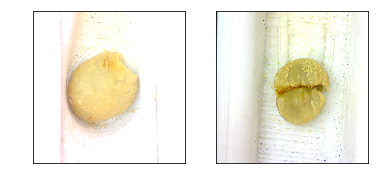

In [7]:
img1 = images[5]
img2 = images[10]
_, ax = plt.subplots(1, 2)
ax[0].imshow(img1)
ax[1].imshow(img2)

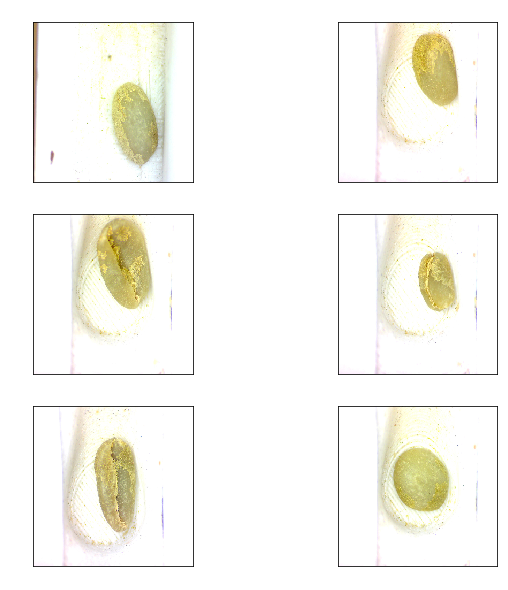

In [8]:
import math
watchedImages = []
plt.rcParams['figure.figsize'] = (10, 10)
_, ax2 = plt.subplots(totalRowToShow, 2)
counter = 0
for i,image in enumerate(images):
    if counter < totalRowToShow*2 and labels[i] == chooseClassIndex:
        ax2[math.floor(counter/2),counter%2].set_title('index ' + str(i), color='w')
        ax2[math.floor(counter/2),counter%2].imshow(image, cmap='jet')
        if isSavePic:
            cv2.imwrite('pic_index{}.png'.format(i), image)
        counter += 1
        watchedImages.append(image)
    if counter == totalRowToShow*2:
        break

In [ ]:
### Visualizing a specific output category

In [ ]:
Lets try visualizing a specific output category. We will pick `normal` which corresponds to imagenet category `20`

In [ ]:
from vis.visualization import visualize_activation
plt.rcParams['figure.figsize'] = (10, 10)
# layer_idx is the imagenet category for 'normal'
img = visualize_activation(model, layer_idx, filter_indices=chooseClassIndex, max_iter=5000, verbose=False)
plt.imshow(img)

In [ ]:
We can see that the loss appears to be converging. So more iterations definitely seem to give better output. One way to get crisper results is to use `Jitter` input_modifier. As the name suggests, `Jitter` moves pixels around in the image. Lets try this out.

In [ ]:
from vis.input_modifiers import Jitter

# layer_idx is the imagenet category for 'normal'
# Jitter 16 pixels along all dimensions to during the optimization process.
img = visualize_activation(model, layer_idx, filter_indices=chooseClassIndex, max_iter=5000, input_modifiers=[Jitter(16)])
plt.imshow(img)

In [ ]:
## Visualizing Conv filters
In a CNN, each Conv layer has several learned *template matching* filters that maximize their output when a similar 
template pattern is found in the input image. First Conv layer is easy to interpret; simply visualize the weights as an image. To see what the Conv layer is doing, a simple option is to apply the filter over raw input pixels. 
Subsequent Conv filters operate over the outputs of previous Conv filters (which indicate the presence or absence 
of some templates), making them hard to interpret.

One way of interpreting them is to generate an input image that maximizes the filter output. This allows us to generate an input that activates the filter.

Lets start by visualizing the second conv layer of CNN model. Here is the Inception-Resnet V2 model for reference.

In [ ]:
from vis.visualization import get_num_filters

# The name of the layer we want to visualize
# You can see this in the model definition.
layer_name = 'conv2d_2'
layer_idx_filter = utils.find_layer_idx(model, layer_name)

# Visualize all filters in this layer.
filters = np.arange(get_num_filters(model.layers[layer_idx_filter]))

# Generate input image for each filter.
vis_images = []
for idx in filters:
    img = visualize_activation(model, layer_idx_filter, filter_indices=idx)
    
    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=8)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

In [ ]:
They mostly seem to match for specific color and directional patterns. Lets try a bunch of other layers.
We will randomly visualize 10 filters within various layers.

In [12]:
selected_indices = []
for layer_name in ['conv2d_3', 'conv2d_4', 'conv2d_5', 'conv2d_6']:
    layer_idx = utils.find_layer_idx(model, layer_name)

    # Visualize all filters in this layer.
    filters = np.random.permutation(get_num_filters(model.layers[layer_idx]))[:10]
    selected_indices.append(filters)

    # Generate input image for each filter.
    vis_images = []
    for idx in filters:
        img = visualize_activation(model, layer_idx, filter_indices=idx)

        # Utility to overlay text on image.
        img = utils.draw_text(img, 'Filter {}'.format(idx))    
        vis_images.append(img)

    # Generate stitched image palette with 5 cols so we get 2 rows.
    stitched = utils.stitch_images(vis_images, cols=5)    
    plt.figure()
    plt.axis('off')
    plt.imshow(stitched)
    plt.show()

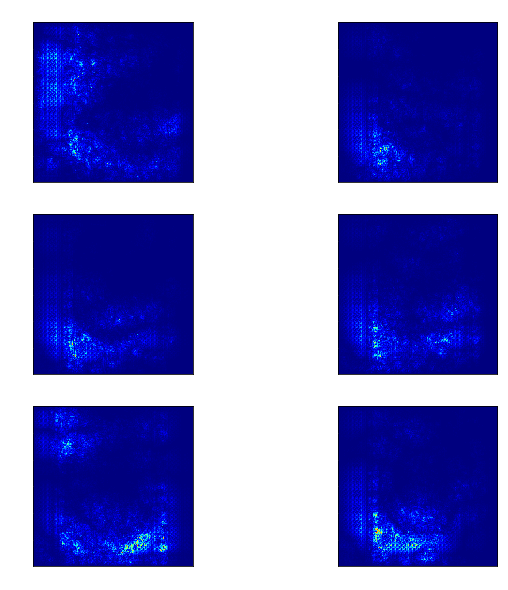

In [13]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, lastLayer)

f, ax = plt.subplots(totalRowToShow, 2)
for i, img in enumerate(watchedImages):
    # layer_idx is the imagenet index corresponding to `normal`
    grads = visualize_saliency(model, layer_idx, filter_indices=chooseClassIndex, seed_input=img)
    
    # visualize grads as heatmap
    ax[math.floor(i/2),i%2].set_title('index ' + str(i), color='w')
    ax[math.floor(i/2),i%2].imshow(grads, cmap='jet')
    if isSavePic:
        cv2.imwrite(os.path.join(save_pic_dir, 'grads_heatmap_index{}.png'.format(i)), grads)
#     ax[i].imshow(grads, cmap='jet')

Time for saliency visualization.

Not that great. Very noisy. Lets try guided and rectified saliency.

To use guided saliency, we need to set `backprop_modifier='guided'`. For rectified saliency or deconv saliency, use `backprop_modifier='relu'`.

<Figure size 720x720 with 0 Axes>

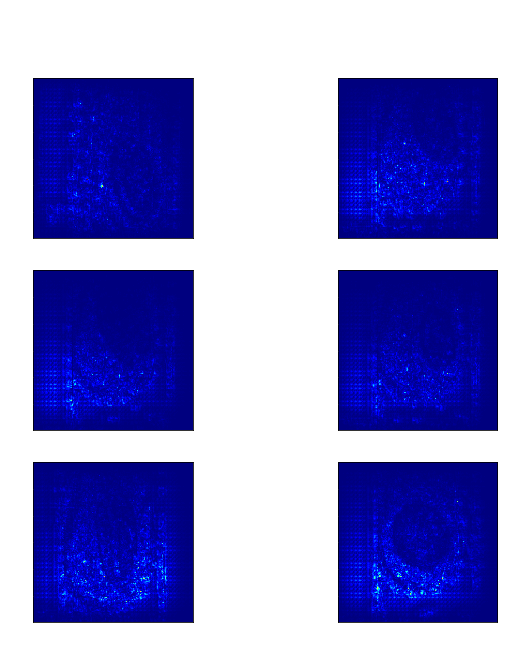

<Figure size 720x720 with 0 Axes>

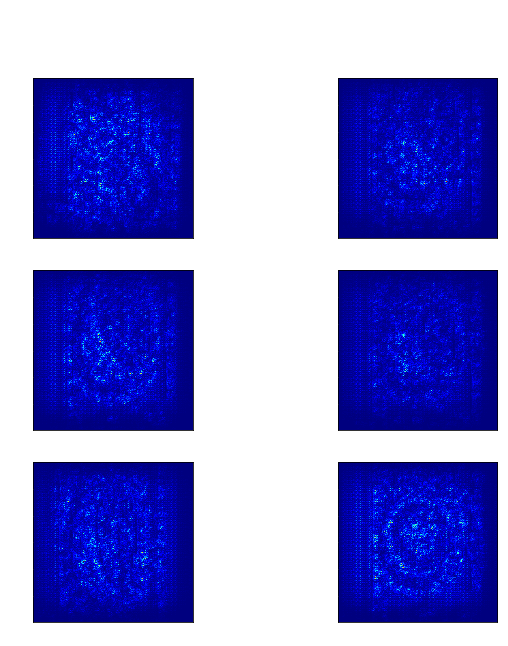

In [14]:
for modifier in ['guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(totalRowToShow, 2)
    plt.suptitle(modifier)
    for i, img in enumerate(watchedImages):    
        # layer_idx is the imagenet index corresponding to `normal`
        grads = visualize_saliency(model, layer_idx, filter_indices=chooseClassIndex, 
                                   seed_input=img, backprop_modifier=modifier)
        # Lets overlay the heatmap onto original image.
        ax[math.floor(i/2),i%2].set_title('index ' + str(i), color='w')
        ax[math.floor(i/2),i%2].imshow(grads, cmap='jet')
        if isSavePic:
            cv2.imwrite(os.path.join(save_pic_dir, 'overlay_heatmap_index{}_modifier_{}.png'.format(i,modifier)), grads)
#         ax[i].imshow(grads, cmap='jet')

guided saliency is definitely better. I am not sure whats going on with rectified saliency.

## grad-CAM - vanilla, guided, rectified

These should contain more detail since they use `Conv` or `Pooling` features that contain more spatial detail which is lost in `Dense` layers. The only additional detail compared to saliency is the `penultimate_layer_idx`. This specifies the pre-layer whose gradients should be used. See this paper for technical details: https://arxiv.org/pdf/1610.02391v1.pdf

By default, if `penultimate_layer_idx` is not defined, it searches for the nearest pre layer. For our architecture, that would be the `bn5c_branch2c` layer after all the `Conv` layers. Here is the model summary for reference.

In [15]:
import matplotlib.cm as cm
from vis.visualization import visualize_cam
from vis.visualization import visualize_saliency, overlay

def showHeatMap(layer_idx, penultimate_layer, isSavePic):
    for modifier in [None, 'guided', 'relu']:
        f, ax = plt.subplots(totalRowToShow, 2)
        plt.suptitle("vanilla" if modifier is None else modifier)
        for i, img in enumerate(watchedImages):    
            # 20 is the imagenet index corresponding to `ouzel`
            grads = visualize_cam(model, layer_idx, filter_indices=chooseClassIndex, 
                                  seed_input=img, penultimate_layer_idx=penultimate_layer,
                                  backprop_modifier=modifier)        
            # Lets overlay the heatmap onto original image. 
            jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
#             jet_heatmap = np.uint8(cm.jet(grads)[..., 0] * 255)
            ax[math.floor(i/2),i%2].set_title('index ' + str(i), color='w')
            ax[math.floor(i/2),i%2].imshow(overlay(jet_heatmap, img))
            if isSavePic:
                cv2.imwrite(os.path.join(save_pic_dir, 'attention_{}_index{}_modifier_{}.png'.format(layer, i, modifier)), overlay(jet_heatmap, img))
    #         ax[i].imshow(overlay(jet_heatmap, img))

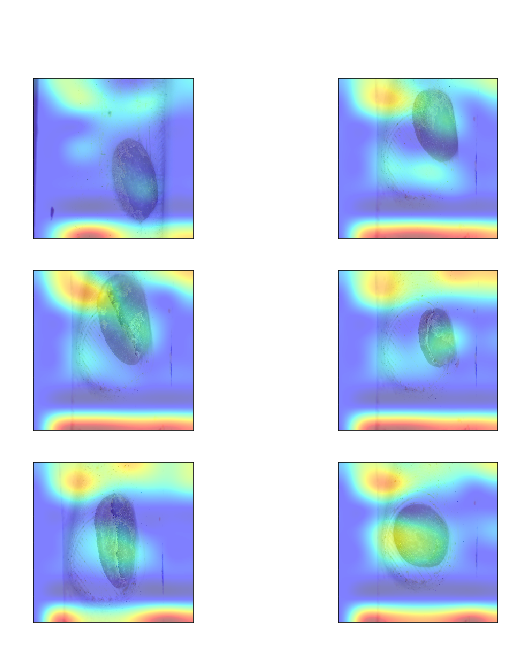

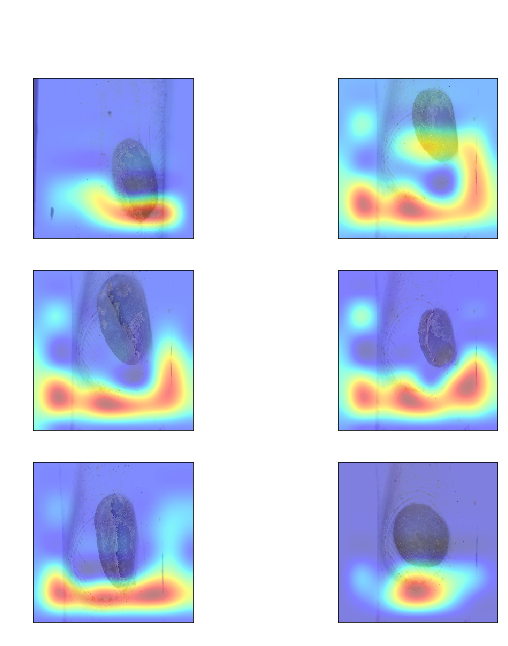

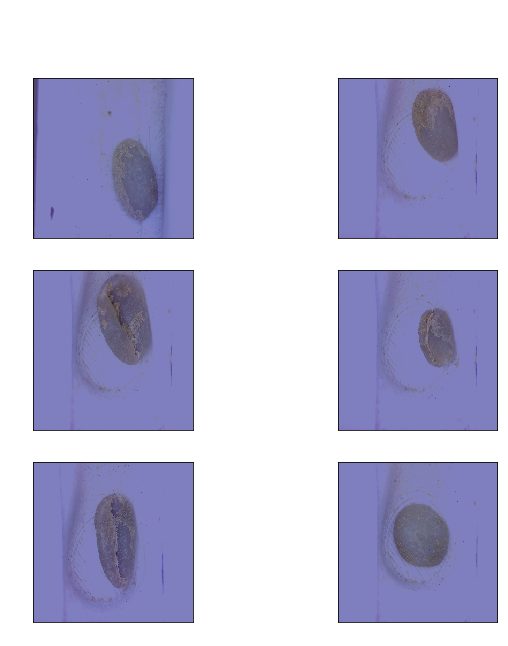

In [16]:
penultimate_layer = utils.find_layer_idx(model, penultimateLayer)
showHeatMap(layer_idx, penultimate_layer, isSavePic)

In [17]:
penultimate_layer = utils.find_layer_idx(model, 'conv2d_202')
showHeatMap(layer_idx, penultimate_layer, isSavePic)

In [ ]:
penultimate_layer = utils.find_layer_idx(model, 'activation_201')
showHeatMap(layer_idx, penultimate_layer, isSavePic)